In [2]:
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt

# Data Visualization

# Resistance Calculation

/var/folders/lc/r3918y9n5y3gb6855vy5yq340000gn/T/ipykernel_2632/3840772935.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=16)


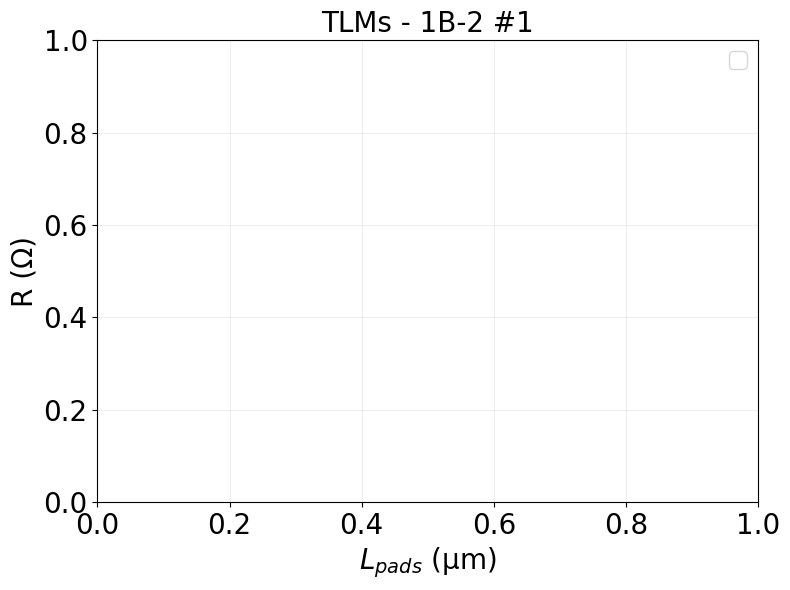

In [3]:
base_path = "Data/Annealing_Test_1B-2/TLMs"
pad_side = "Both"  

def analyze_pads(side, base_path, ignore_distances=None):
    if ignore_distances is None:
        ignore_distances = []

    pad_prefix = f"{side}_Pads_"
    dir_pattern = os.path.join(base_path, pad_prefix + "*")
    pad_dirs = glob.glob(dir_pattern)

    distances_um = []
    resistances_ohms = []

    for folder in pad_dirs:
        # Extract the label after '<side>_Pads_'
        match = re.search(rf"{pad_prefix}(\d+)", folder)
        if not match:
            continue
        label_str = match.group(1)
        
        # Convert the label to a distance:
        # e.g. "12" => first_digit = 1 => distance=5um
        first_digit = int(label_str[0])
        distance = 5 * first_digit

        file_pattern = os.path.join(folder, "*forward*")
        forward_files = glob.glob(file_pattern)
        if not forward_files:
            continue

        forward_files.sort()
        last_forward_file = forward_files[-1]

        # Load data
        data = np.loadtxt(last_forward_file, skiprows=1)
        V = data[:, 0]
        I_mA = data[:, 1]

        mask = (V >= 1.5)
        V_fit = V[mask]
        I_fit = I_mA[mask]

        if len(V_fit) < 2:
            continue

        slope_mAperV, intercept_mA = np.polyfit(V_fit, I_fit, 1)
        R_ohms = 1000.0 / slope_mAperV

        distances_um.append(distance)
        resistances_ohms.append(R_ohms)

    # Sort results
    if distances_um:
        distances_um, resistances_ohms = zip(*sorted(zip(distances_um, resistances_ohms)))
        distances_um = list(distances_um)
        resistances_ohms = list(resistances_ohms)
    else:
        distances_um, resistances_ohms = [], []

    # Filter out any distances we want to ignore:
    # e.g. skip 25µm or any set of distances in 'ignore_distances'
    final_dist = []
    final_res = []
    for d, r in zip(distances_um, resistances_ohms):
        if d not in ignore_distances:
            final_dist.append(d)
            final_res.append(r)

    return final_dist, final_res



plt.figure(figsize=(8, 6))

if pad_side == "Both":

    dist_left, res_left = analyze_pads("Left", base_path, ignore_distances=[30])

    dist_right, res_right = analyze_pads("Right", base_path)

    if dist_left:
        plt.plot(dist_left, res_left, 'o--', markersize=10,
                 color='crimson', label="Left Pads")

    if dist_right:
        plt.plot(dist_right, res_right, 's--', markersize=10,
                 color='darkblue', label="Right Pads")

    all_distances = dist_left + dist_right
    if all_distances:
        xmin = min(all_distances)
        xmax = max(all_distances)
        plt.xlim(left=0, right=xmax * 1.1) 
    else:
        plt.xlim(left=0)

else:
    dist, res = analyze_pads(pad_side, base_path, ignore_distances=[25])
    if dist:
        plt.plot(dist, res, 'o--', color = 'darkblue', markersize=10, label=f"{pad_side} Pads")
        plt.xlim(left=0, right=max(dist)*1.1)
    else:
        plt.xlim(left=0)


plt.ylim(bottom=0)  # Start y-axis from 0
plt.xlabel("$L_{pads}$ (µm)", fontsize=20)
plt.ylabel("R (Ω)", fontsize=20)
plt.title("TLMs - 1B-2 #1", fontsize=20)

plt.grid(True, alpha=0.2)
plt.legend(fontsize=16)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(20)
plt.tight_layout()
plt.show()


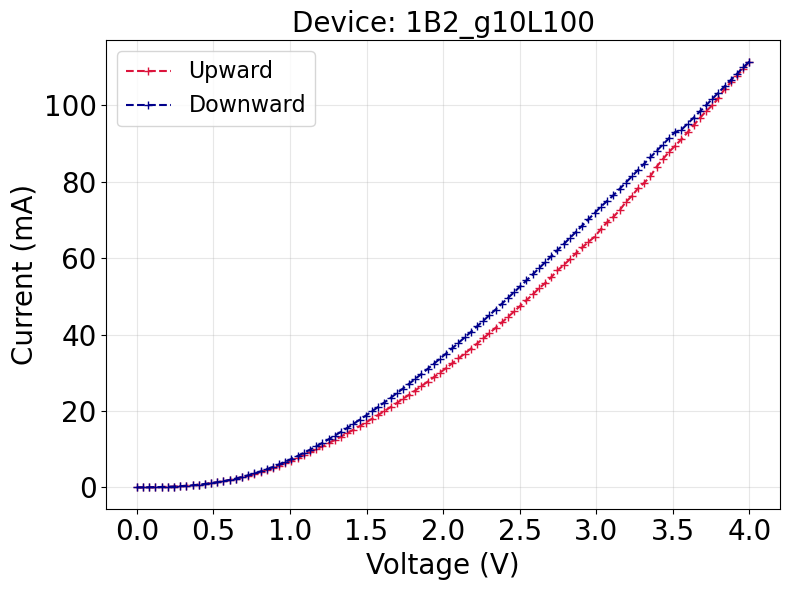

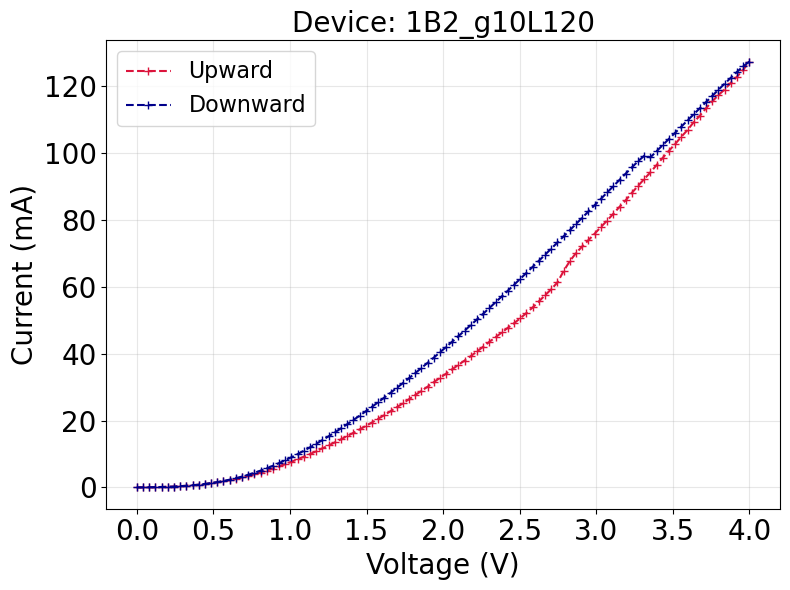

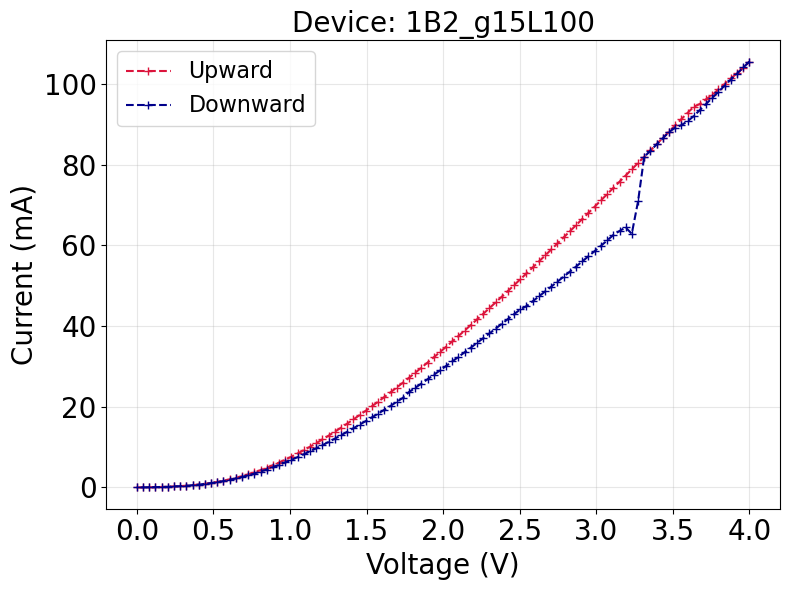

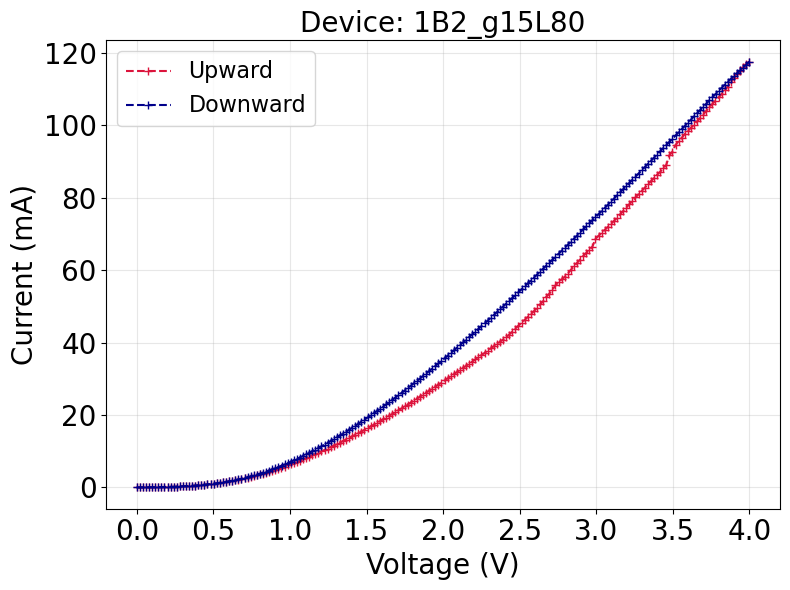

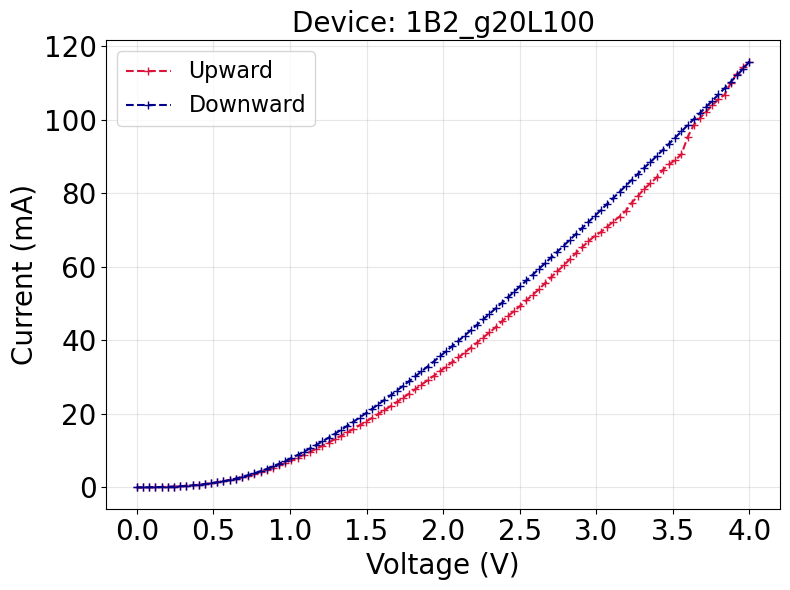

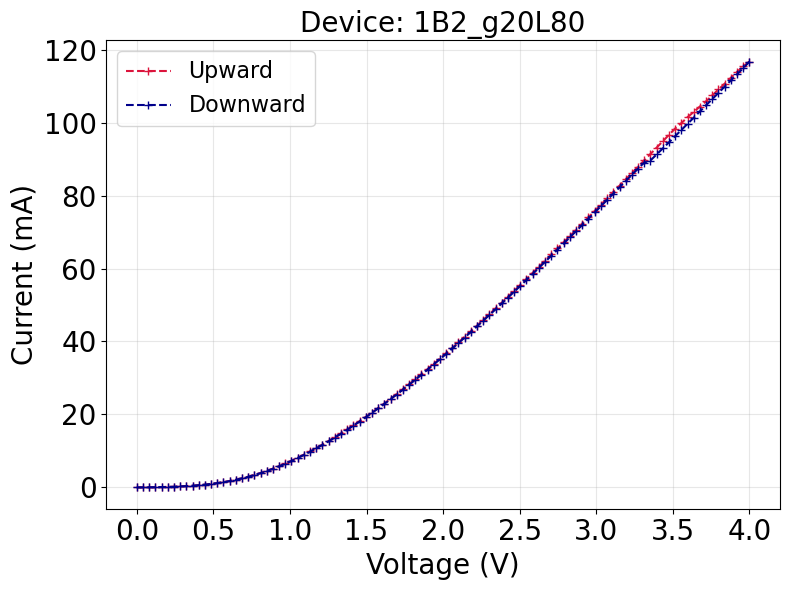

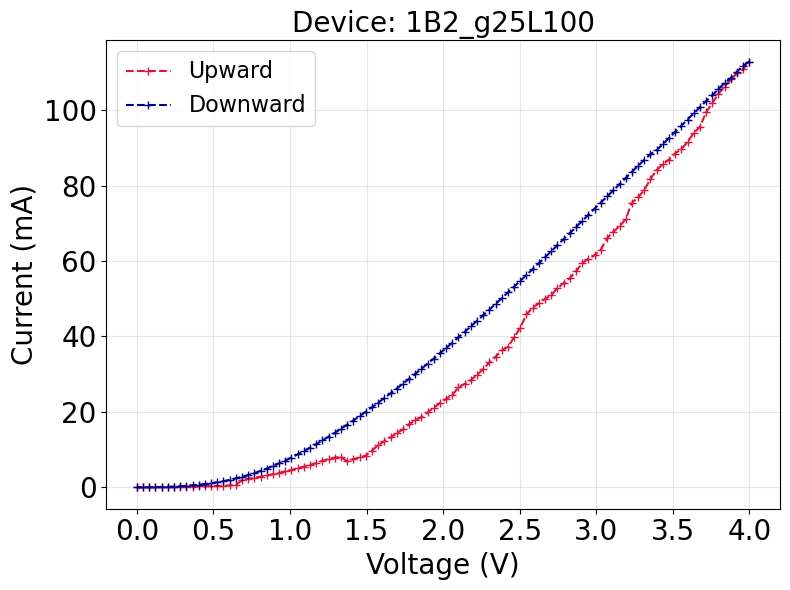

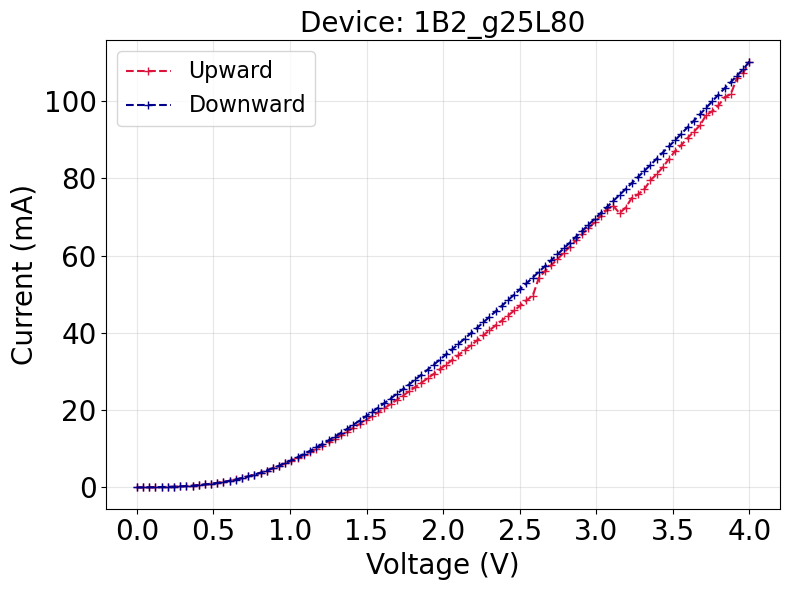

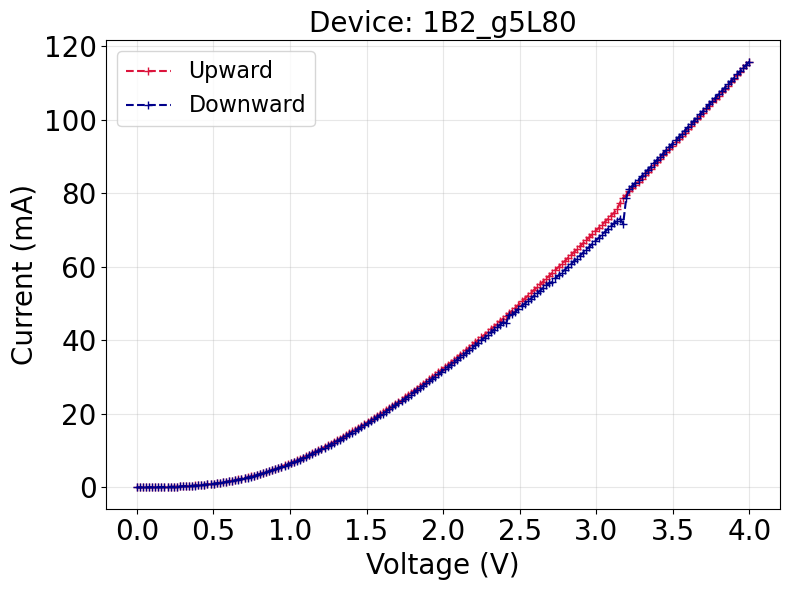

In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_iv_data(base_path):
    is_tlm = "tlm" in base_path.lower()
    all_dirs = sorted([d for d in glob.glob(os.path.join(base_path, "*")) if os.path.isdir(d)])
    dir_dict = defaultdict(dict)

    if is_tlm:
        for folder in all_dirs:
            name = os.path.basename(folder)
            match = re.search(r"(\d+)", name)
            if not match:
                continue
            distance = 5 * int(match.group(1)[0])
            label = f"{distance} µm"
            try:
                fwd_file = sorted(glob.glob(os.path.join(folder, "*upward*")))[-1]
                rev_file = sorted(glob.glob(os.path.join(folder, "*downward*")))[-1]
                data_fwd = np.loadtxt(fwd_file, skiprows=1)
                data_rev = np.loadtxt(rev_file, skiprows=1)
            except Exception as e:
                print(f"Error loading {name}: {e}")
                continue
            plot_device(label, [(data_fwd, fwd_file), (data_rev, rev_file)], negate=False)

    else:
        for folder in all_dirs:
            name = os.path.basename(folder)
            if name.endswith("_downward"):
                base_name = name.replace("_downward", "")
                dir_dict[base_name]["downward"] = folder
            else:
                dir_dict[name]["upward"] = folder

        for base_name, paths in dir_dict.items():
            label = base_name
            curves = []

            for direction in ["upward", "downward"]:
                if direction in paths:
                    folder = paths[direction]
                    try:
                        fwd_file = sorted(glob.glob(os.path.join(folder, "*upward*")))[-1]
                        rev_file = sorted(glob.glob(os.path.join(folder, "*downward*")))[-1]
                        data_fwd = np.loadtxt(fwd_file, skiprows=1)
                        data_rev = np.loadtxt(rev_file, skiprows=1)

                        if direction == "reverse":
                            data_fwd[:, :2] *= -1
                            data_rev[:, :2] *= -1

                        curves.append((data_fwd, fwd_file))
                        curves.append((data_rev, rev_file))
                    except Exception as e:
                        print(f"Error loading {folder}: {e}")
                        continue

            plot_device(label, curves)

def plot_device(label, data_files, negate=False):
    plt.figure(figsize=(8, 6))
    added_labels = set()

    for data, filename in data_files:
        V, I = data[:, 0], data[:, 1]

        if "upward" in filename.lower():
            sweep_type = "Upward"
            color = "crimson"
        elif "downward" in filename.lower():
            sweep_type = "Downward"
            color = "darkblue"
        else:
            sweep_type = "Unknown"
            color = "gray"

        # Only add label once per sweep type
        legend_label = sweep_type if sweep_type not in added_labels else None
        added_labels.add(sweep_type)

        plt.plot(V, I, '+--', label=legend_label, color=color)

    plt.xlabel("Voltage (V)", fontsize=20)
    plt.ylabel("Current (mA)", fontsize=20)
    plt.title(f"Device: {label}", fontsize=20)
    plt.xticks(fontsize=20)  # ← Tick font size
    plt.yticks(fontsize=20)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=16, loc='best')
    plt.tight_layout()
    plt.show()


plot_iv_data("measurements")
        
        
